## 准备工作

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
# 读取数据集
data = pd.read_csv(r'data/test_data.csv')
data.columns = [col.upper() for col in data.columns]

In [3]:
# 导入gbdt_var的方法
from gbdt_var import get_gbdt_path_var, get_data_gbdt, get_head_rule, get_rule_df, get_lr_model, get_lr_proba

# 导入数据集比较的代码
os.chdir('../常用代码')
from common_function import dataframe_compare_all, dataframe_compare_sigle

# 导入自动建模代码
os.chdir('../../Auto-Modeling/Auto-Modeling')
import auto_modeling as am

In [4]:
# 划分数据集
X_train, Y_train, X_test, Y_test, X_time_test, Y_time_test = am.data_split(
    data, test_size=0.3, time_test_type=False)

>> 数据集划分成功,无跨时间测试集
>> 训练集样本数: 23842
>> 测试集样本数: 10219
>> 训练集目标情况如下:
   训练集TARGET为 0 的数量: 21451  占比: 89.97%
   训练集TARGET为 1 的数量: 2391  占比: 10.03%


In [18]:
# 特征选择
keep_cols = am.feature_select(X_train, Y_train, cols_number='auto', verbose=False)[0]

>> 根据缺失率删除 0 个变量
>> 根据同质性删除 0 个变量
>> 根据最大计数类别删除 1 个变量
>> 根据相关性删除 0 个变量
>> 特征重要度迭代次数 |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■   根据条件提前停止迭代
>> 根据特征重要度最终保留 23 个变量
>> 具体保留变量如下:
   ['CREDIT_SCORE', 'APPL_AUTH_TIME', 'ACCOUNT_GRADE', 'BANKPRED', 'OVERTIME_DELTA', 'ID_LEN', 'COUNT_REC_INFO', 'BANK_RATE_AVG', 'USE_RATE', 'SEX', 'LATEST_APPL_ORDER', 'AMT_ORDER_SKEW', 'ORDER_NULL_AVG', 'DUR_DAY', 'NULL_COUNT', 'AUTH_TIME_DAY', 'AMT_ORDER_STD', 'ORDERPRED', 'AMT_ORDER_MEAN', 'AMT_ORDER_SUM', 'EVENING_ORDER_COUNT', 'WEEKDAY_COUNT', 'CHUXUKA_COUNT']


In [6]:
# 转换数据集
X_train_trans, X_test_trans, X_time_test_trans, num_cols, char_cols = am.get_coltype_datalist(
    X_train, X_test, X_time_test, keep_cols)

# 封装DataFrameMapper
mapper = am.get_mapper(num_cols, char_cols)

>> 开始使用贝叶斯优化的TPE算法对 GBDT 进行超参数优化
100%|██████████████████████████████████████████████| 100/100 [1:11:11<00:00, 28.92s/it, best loss: -0.8512065222910176]
>> GBDT 最优超参数交叉验证结果为：训练集平均AUC：0.9322  验证集平均AUC：0.8512
>> 模型超参数优化完成,最优模型为 GBDT


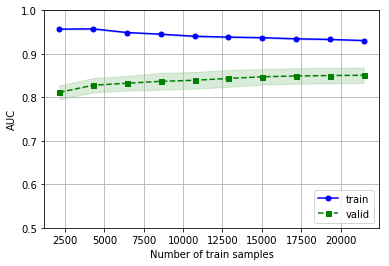

In [21]:
#调参
best_para_dict = am.para_optimize(X_train_trans, Y_train, mapper, model_list=['gbdt'])

In [22]:
best_para_dict

{'best': {'gbdt': {'learning_rate': 0.027360187181996815,
   'max_depth': 9,
   'max_features': 0.6695605900761501,
   'min_samples_leaf': 70,
   'min_samples_split': 340,
   'n_estimators': 220,
   'subsample': 0.9968467898569264}},
 'xgb': {},
 'lgbm': {},
 'gbdt': {'learning_rate': 0.027360187181996815,
  'max_depth': 9,
  'max_features': 0.6695605900761501,
  'min_samples_leaf': 70,
  'min_samples_split': 340,
  'n_estimators': 220,
  'subsample': 0.9968467898569264},
 'rf': {}}

In [8]:
# 建立模型
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(**best_para_dict['gbdt'], random_state=1234)
model

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.027360187181996815, loss='deviance',
              max_depth=9, max_features=0.6695605900761501,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=70,
              min_samples_split=340, min_weight_fraction_leaf=0.0,
              n_estimators=220, n_iter_no_change=None, presort='auto',
              random_state=1234, subsample=0.9968467898569264, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False)

## 衍生GBDT变量

In [9]:
# 衍生gbdt变量
gbdt_path_var = get_gbdt_path_var(X_train_trans, model, y=Y_train, one_hot=False)
gbdt_path_var.head()

,CREDIT_SCORE <= 379.5;APPL_AUTH_TIME <= -23.5;ID_LEN <= 19.0;NULL_COUNT <= 6.5,CREDIT_SCORE <= 379.5;APPL_AUTH_TIME <= -23.5;ID_LEN <= 19.0;NULL_COUNT > 6.5,CREDIT_SCORE <= 379.5;APPL_AUTH_TIME <= -23.5;ID_LEN > 19.0;ACCOUNT_GRADE <= 0.5,CREDIT_SCORE <= 379.5;APPL_AUTH_TIME <= -23.5;ID_LEN > 19.0;ACCOUNT_GRADE > 0.5,CREDIT_SCORE <= 379.5;APPL_AUTH_TIME > -23.5;ACCOUNT_GRADE <= -4.5;AUTH_TIME_DAY <= 0.0,CREDIT_SCORE <= 379.5;APPL_AUTH_TIME > -23.5;ACCOUNT_GRADE <= -4.5;AUTH_TIME_DAY > 0.0,CREDIT_SCORE <= 379.5;APPL_AUTH_TIME > -23.5;ACCOUNT_GRADE > -4.5;CHUXUKA_COUNT <= 0.316667,CREDIT_SCORE <= 379.5;APPL_AUTH_TIME > -23.5;ACCOUNT_GRADE > -4.5;CHUXUKA_COUNT > 0.316667;BANKPRED <= 0.03098;APPL_AUTH_TIME <= -7.5;LATEST_APPL_ORDER <= 10477070.0;BANKPRED <= 0.028894,CREDIT_SCORE <= 379.5;APPL_AUTH_TIME > -23.5;ACCOUNT_GRADE > -4.5;CHUXUKA_COUNT > 0.316667;BANKPRED <= 0.03098;APPL_AUTH_TIME <= -7.5;LATEST_APPL_ORDER <= 10477070.0;BANKPRED > 0.028894;ID_LEN <= 19.0,CREDIT_SCORE <= 379.5;APPL_AUTH_TIME > -23.5;ACCOUNT_GRADE > -4.5;CHUXUKA_COUNT > 0.316667;BANKPRED <= 0.03098;APPL_AUTH_TIME <= -7.5;LATEST_APPL_ORDER <= 10477070.0;BANKPRED > 0.028894;ID_LEN > 19.0,...,USE_RATE <= 1.037761;SEX <= 1.5;CREDIT_SCORE <= 575.5;USE_RATE <= 0.993809;DUR_DAY <= 1.44733955424256e+17;USE_RATE <= 0.99038;DUR_DAY > 9.838677864952627e+16,USE_RATE <= 1.037761;SEX <= 1.5;CREDIT_SCORE <= 575.5;USE_RATE <= 0.993809;DUR_DAY <= 1.44733955424256e+17;USE_RATE > 0.99038,USE_RATE <= 1.037761;SEX <= 1.5;CREDIT_SCORE <= 575.5;USE_RATE <= 0.993809;DUR_DAY > 1.44733955424256e+17,USE_RATE <= 1.037761;SEX <= 1.5;CREDIT_SCORE <= 575.5;USE_RATE > 0.993809;APPL_AUTH_TIME <= 78.5;WEEKDAY_COUNT <= 0.914855;ACCOUNT_GRADE <= 1.5,USE_RATE <= 1.037761;SEX <= 1.5;CREDIT_SCORE <= 575.5;USE_RATE > 0.993809;APPL_AUTH_TIME <= 78.5;WEEKDAY_COUNT <= 0.914855;ACCOUNT_GRADE > 1.5,USE_RATE <= 1.037761;SEX <= 1.5;CREDIT_SCORE > 575.5;APPL_AUTH_TIME <= 11.5;APPL_AUTH_TIME <= -12.5,USE_RATE <= 1.037761;SEX <= 1.5;CREDIT_SCORE > 575.5;APPL_AUTH_TIME <= 11.5;APPL_AUTH_TIME > -12.5;ORDER_NULL_AVG <= 1.58304,USE_RATE <= 1.037761;SEX <= 1.5;CREDIT_SCORE > 575.5;APPL_AUTH_TIME <= 11.5;APPL_AUTH_TIME > -12.5;ORDER_NULL_AVG > 1.58304,USE_RATE <= 1.037761;SEX > 1.5;AUTH_TIME_DAY <= 27.5;NULL_COUNT > 3.5;CREDIT_SCORE > 315.5;LATEST_APPL_ORDER <= 3120174.0;WEEKDAY_COUNT <= 0.612573;NULL_COUNT <= 6.5,USE_RATE <= 1.037761;SEX > 1.5;AUTH_TIME_DAY <= 27.5;NULL_COUNT > 3.5;CREDIT_SCORE > 315.5;LATEST_APPL_ORDER <= 3120174.0;WEEKDAY_COUNT <= 0.612573;NULL_COUNT > 6.5
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# 回溯gbdt变量给其他数据集
X_train_gbdt = get_data_gbdt(X_train_trans, gbdt_path_var.columns)
X_train_gbdt.head()

,CREDIT_SCORE <= 379.5;APPL_AUTH_TIME <= -23.5;ID_LEN <= 19.0;NULL_COUNT <= 6.5,CREDIT_SCORE <= 379.5;APPL_AUTH_TIME <= -23.5;ID_LEN <= 19.0;NULL_COUNT > 6.5,CREDIT_SCORE <= 379.5;APPL_AUTH_TIME <= -23.5;ID_LEN > 19.0;ACCOUNT_GRADE <= 0.5,CREDIT_SCORE <= 379.5;APPL_AUTH_TIME <= -23.5;ID_LEN > 19.0;ACCOUNT_GRADE > 0.5,CREDIT_SCORE <= 379.5;APPL_AUTH_TIME > -23.5;ACCOUNT_GRADE <= -4.5;AUTH_TIME_DAY <= 0.0,CREDIT_SCORE <= 379.5;APPL_AUTH_TIME > -23.5;ACCOUNT_GRADE <= -4.5;AUTH_TIME_DAY > 0.0,CREDIT_SCORE <= 379.5;APPL_AUTH_TIME > -23.5;ACCOUNT_GRADE > -4.5;CHUXUKA_COUNT <= 0.316667,CREDIT_SCORE <= 379.5;APPL_AUTH_TIME > -23.5;ACCOUNT_GRADE > -4.5;CHUXUKA_COUNT > 0.316667;BANKPRED <= 0.03098;APPL_AUTH_TIME <= -7.5;LATEST_APPL_ORDER <= 10477070.0;BANKPRED <= 0.028894,CREDIT_SCORE <= 379.5;APPL_AUTH_TIME > -23.5;ACCOUNT_GRADE > -4.5;CHUXUKA_COUNT > 0.316667;BANKPRED <= 0.03098;APPL_AUTH_TIME <= -7.5;LATEST_APPL_ORDER <= 10477070.0;BANKPRED > 0.028894;ID_LEN <= 19.0,CREDIT_SCORE <= 379.5;APPL_AUTH_TIME > -23.5;ACCOUNT_GRADE > -4.5;CHUXUKA_COUNT > 0.316667;BANKPRED <= 0.03098;APPL_AUTH_TIME <= -7.5;LATEST_APPL_ORDER <= 10477070.0;BANKPRED > 0.028894;ID_LEN > 19.0,...,USE_RATE <= 1.037761;SEX <= 1.5;CREDIT_SCORE <= 575.5;USE_RATE <= 0.993809;DUR_DAY <= 1.44733955424256e+17;USE_RATE <= 0.99038;DUR_DAY > 9.838677864952627e+16,USE_RATE <= 1.037761;SEX <= 1.5;CREDIT_SCORE <= 575.5;USE_RATE <= 0.993809;DUR_DAY <= 1.44733955424256e+17;USE_RATE > 0.99038,USE_RATE <= 1.037761;SEX <= 1.5;CREDIT_SCORE <= 575.5;USE_RATE <= 0.993809;DUR_DAY > 1.44733955424256e+17,USE_RATE <= 1.037761;SEX <= 1.5;CREDIT_SCORE <= 575.5;USE_RATE > 0.993809;APPL_AUTH_TIME <= 78.5;WEEKDAY_COUNT <= 0.914855;ACCOUNT_GRADE <= 1.5,USE_RATE <= 1.037761;SEX <= 1.5;CREDIT_SCORE <= 575.5;USE_RATE > 0.993809;APPL_AUTH_TIME <= 78.5;WEEKDAY_COUNT <= 0.914855;ACCOUNT_GRADE > 1.5,USE_RATE <= 1.037761;SEX <= 1.5;CREDIT_SCORE > 575.5;APPL_AUTH_TIME <= 11.5;APPL_AUTH_TIME <= -12.5,USE_RATE <= 1.037761;SEX <= 1.5;CREDIT_SCORE > 575.5;APPL_AUTH_TIME <= 11.5;APPL_AUTH_TIME > -12.5;ORDER_NULL_AVG <= 1.58304,USE_RATE <= 1.037761;SEX <= 1.5;CREDIT_SCORE > 575.5;APPL_AUTH_TIME <= 11.5;APPL_AUTH_TIME > -12.5;ORDER_NULL_AVG > 1.58304,USE_RATE <= 1.037761;SEX > 1.5;AUTH_TIME_DAY <= 27.5;NULL_COUNT > 3.5;CREDIT_SCORE > 315.5;LATEST_APPL_ORDER <= 3120174.0;WEEKDAY_COUNT <= 0.612573;NULL_COUNT <= 6.5,USE_RATE <= 1.037761;SEX > 1.5;AUTH_TIME_DAY <= 27.5;NULL_COUNT > 3.5;CREDIT_SCORE > 315.5;LATEST_APPL_ORDER <= 3120174.0;WEEKDAY_COUNT <= 0.612573;NULL_COUNT > 6.5
26242,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
28803,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24551,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31764,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# 对两个数据集是否一致进行检验
# 数据集还与下面代码操作后的数据集一致
# X_train_gbdt = model.apply(X_train_mapper)[:, :, 0]
# enc = OneHotEncoder()
# X_train_gbdt = np.array(enc.fit_transform(X_train_gbdt).toarray())
# 但由于get_gbdt_path_var有进行一个去重的操作，列数可能会不同，这里不再检验

gbdt_path_var.index = X_train_gbdt.index
compare_all = dataframe_compare_all(gbdt_path_var.reset_index(), X_train_gbdt.reset_index(), 'index', verbose=1)

# 两个数据集一定是完全一致的，如果不一致一般因为有变量的小数位过长，在提取子树结构时，每个节点判断的阈值精度取了6位
# 这精准的6位有可能让路径的信息损失，需让原数据集的小数位进行四舍五入，或者将get_gbdt_path_var的参数precision增大

第一个数据集的维度: (23842, 11850)
第二个数据集的维度: (23842, 11850)
两个数据集公共变量数: 11849
两个数据集相同 index 样本数: 23842
变量 CREDIT_SCORE > -4.5;ACCOUNT_GRADE > -4.5;ORDER_NULL_AVG <= 3.231801;BANKPRED <= 0.030044;USE_RATE <= 0.862438;AMT_ORDER_STD > 1190.839417;AMT_ORDER_STD <= 1743.890442 一致率：0.9999580572099656
变量 CREDIT_SCORE > 375.5;NULL_COUNT <= 6.5;CREDIT_SCORE > 486.5;BANKPRED <= 0.031824;ID_LEN <= 19.0;USE_RATE > 0.862438;APPL_AUTH_TIME > 285.0 一致率：0.9999580572099656
变量 ACCOUNT_GRADE > -4.5;SEX <= 1.5;CREDIT_SCORE <= 575.5;AMT_ORDER_SUM <= 53563.904297;NULL_COUNT <= 6.5;APPL_AUTH_TIME <= 734.0;APPL_AUTH_TIME > -86.5;USE_RATE <= 0.862438;USE_RATE > -4.5 一致率：0.9999580572099656
变量 ACCOUNT_GRADE > -4.5;SEX <= 1.5;CREDIT_SCORE <= 575.5;AMT_ORDER_SUM <= 53563.904297;NULL_COUNT <= 6.5;APPL_AUTH_TIME <= 734.0;APPL_AUTH_TIME > -86.5;USE_RATE > 0.862438;ORDER_NULL_AVG > 2.147895 一致率：0.9999580572099656
变量 CREDIT_SCORE > 362.5;APPL_AUTH_TIME > 67.5;APPL_AUTH_TIME > 73.5;USE_RATE > 0.862438;ORDER_NULL_AVG > 2.161105;

In [12]:
# 增大精度
gbdt_path_var = get_gbdt_path_var(X_train_trans, model, y=Y_train, one_hot=False, precision=10)
X_train_gbdt = get_data_gbdt(X_train_trans, gbdt_path_var.columns)
gbdt_path_var.index = X_train_gbdt.index
compare_all = dataframe_compare_all(gbdt_path_var.reset_index(), X_train_gbdt.reset_index(), 'index', verbose=1)

第一个数据集的维度: (23842, 11850)
第二个数据集的维度: (23842, 11850)
两个数据集公共变量数: 11849
两个数据集相同 index 样本数: 23842
所有变量均一致


## 规则提取

In [13]:
# 查看目标占比前8的规则
get_head_rule(X_train_gbdt, Y_train, head=8)

总样本目标为 1 的样本占比为: 0.1003

根据目标占比,提取前 8 个规则,具体规则如下:
>> 规则 1: 覆盖率 0.003  目标占比 0.625
   CREDIT_SCORE <= 362.5;BANKPRED <= 0.0309798662;BANKPRED > 0.0217065336;BANKPRED > 0.0220806189;BANKPRED <= 0.0288935956;NULL_COUNT <= 6.5;AUTH_TIME_DAY <= 0.0

>> 规则 2: 覆盖率 0.0039  目标占比 0.6064
   ACCOUNT_GRADE > -4.5;APPL_AUTH_TIME > -20.5;CREDIT_SCORE <= 362.5;BANKPRED <= 0.0309798662;CREDIT_SCORE > 293.5;BANKPRED <= 0.0288935956;ID_LEN <= 19.0;AUTH_TIME_DAY <= 0.0

>> 规则 3: 覆盖率 0.004  目标占比 0.6042
   ACCOUNT_GRADE > -4.5;CREDIT_SCORE <= 379.5;APPL_AUTH_TIME > -10.5;BANK_RATE_AVG > 0.0217653792;BANKPRED > 0.0309798662;CREDIT_SCORE > -4.5;USE_RATE <= -4.5;APPL_AUTH_TIME <= 115.5;AMT_ORDER_SKEW > 0.5774277151

>> 规则 4: 覆盖率 0.0077  目标占比 0.5956
   CREDIT_SCORE <= 362.5;BANKPRED > 0.0309798662;BANKPRED > 0.0314750858;CREDIT_SCORE > 294.0;APPL_AUTH_TIME <= 50.5;BANKPRED <= 0.1369128749;CREDIT_SCORE <= 329.5;AUTH_TIME_DAY <= 4.5

>> 规则 5: 覆盖率 0.0029  目标占比 0.5857
   ACCOUNT_GRADE > -4.5;CREDIT_SCORE <= 362.5;AP

In [14]:
# 获取所有规则信息的数据集
rule_df = get_rule_df(X_train_gbdt, Y_train)
rule_df.head()

,rule,cover,target
0,CREDIT_SCORE <= 362.5;BANKPRED <= 0.0309798662...,0.0030,0.6250
1,ACCOUNT_GRADE > -4.5;APPL_AUTH_TIME > -20.5;CR...,0.0039,0.6064
2,ACCOUNT_GRADE > -4.5;CREDIT_SCORE <= 379.5;APP...,0.0040,0.6042
3,CREDIT_SCORE <= 362.5;BANKPRED > 0.0309798662;...,0.0077,0.5956
4,ACCOUNT_GRADE > -4.5;CREDIT_SCORE <= 362.5;APP...,0.0029,0.5857


## 逻辑回归

In [15]:
# 训练逻辑回归模型
# 选择的变量数与C呈正相关
intercept, coef, cols = get_lr_model(X_train_gbdt, Y_train, C=0.01)

在L1正则项系数为 0.01 下,训练出的逻辑回归模型共选择了 32 个变量
交叉验证结果为:  训练集平均AUC: 0.8096  验证集平均AUC: 0.8071

逻辑回归模型如下:
1 / (1 + e^(1.1527312554947835 - 0.10587729848069462 * X[1] - 0.22637171420016958 * X[2] - 0.1393058217680669 * X[3] - 0.020930831378182916 * X[4] + 0.30161517446455444 * X[5] + 0.0012477098168467435 * X[6] - 0.00938348836879521 * X[7] - 0.021193398234121533 * X[8] + 0.25674676201110436 * X[9] - 0.1190741451243337 * X[10] - 0.11536938633832616 * X[11] + 0.14418008917328623 * X[12] - 0.06916905430055442 * X[13] + 0.13641015681057203 * X[14] - 0.1655008848413723 * X[15] + 0.05661303986922289 * X[16] - 0.015274252982060811 * X[17] + 0.0795421250060848 * X[18] + 0.03834112139927904 * X[19] - 0.0005035641427966378 * X[20] + 0.5263473309014012 * X[21] + 0.28918556938308754 * X[22] - 0.07569243231570366 * X[23] + 0.0038417355819300014 * X[24] + 0.0479675569785015 * X[25] + 0.11640082832154112 * X[26] + 0.01699008487564195 * X[27] + 0.1686146497238901 * X[28] + 0.0921067603833908 * X[29] + 0.81641885

In [16]:
# 计算预测的概率值
lr_proba = get_lr_proba(intercept, coef, cols, X_train_gbdt)
lr_proba[:5]

26242    0.127230
28803    0.088854
7655     0.029691
24551    0.015293
31764    0.163832
dtype: float64

In [17]:
# 对测试集回溯GBDT衍生变量，并预测概率值，查看AUC、KS
X_test_gbdt = get_data_gbdt(X_test_trans, gbdt_path_var.columns)
test_proba = get_lr_proba(intercept, coef, cols, X_test_gbdt, Y_test)

AUC: 0.8071  KS: 0.4882
